In [100]:
!pip install xgboost
!pip install graphviz 
!pip install tensorflow
!pip install imblearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2
from modules.PlottingUtils import plot_cm
from modules.PreProcessingUtils import GetDummies, split_train_test, sample_cat
from modules.PipelineUtils import NumericalCategoricalSelector, DimensionReducer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [3]:
#classifier dependencies
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [4]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

In [5]:
tv_df = pd.read_pickle(r'E:\entrevistas\dataset\tv_df_extrafeatures.pkl')
#tv_df = pd.read_pickle(r'E:\entrevistas\dataset\tv_final.pkl')
#tv_df = pd.read_pickle('./data/tv_final.pkl')

# Feature engineering

In [6]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


def date(row):
    s_registration_timestamp = pd.Timestamp(row['seller_registration_date']).tz_convert(None)
    row['seller_registration_year'] = s_registration_timestamp.year
    row['seller_registration_month'] = s_registration_timestamp.month
    row['seller_registration_day'] = s_registration_timestamp.month
    
    now = datetime.now()
    end_date = datetime.fromtimestamp(datetime.now().timestamp())
    try:
        #if timestamp is none
        start_date = datetime.fromtimestamp(s_registration_timestamp.timestamp())
        
        difference_in_years = relativedelta(end_date, start_date).years
        difference_in_months = relativedelta(end_date, start_date).months
        #difference_in_days = relativedelta(end_date, start_date).days

        month_diff = difference_in_years * 12 + difference_in_months

        row['seller_years_active'] = difference_in_years
        row['seller_months_active'] = month_diff

        time_diff = now - s_registration_timestamp
        row['seller_days_active'] = time_diff.days
    
    except:
        #all nan
        row['seller_years_active'] = s_registration_timestamp.year
        row['seller_months_active'] = s_registration_timestamp.year
        row['seller_days_active'] = s_registration_timestamp.year
        
        
    
    
    
    item_pub_startt = pd.Timestamp(row['publication_start_time']).tz_convert(None)
    row['item_publication_year'] = item_pub_startt.year
    row['item_publication_month'] = item_pub_startt.month
    row['item_publication_day'] = item_pub_startt.month

    try:
        #if timestamp is none
        start_date = datetime.fromtimestamp(item_pub_startt.timestamp())

        difference_in_years = relativedelta(end_date, start_date).years
        difference_in_months = relativedelta(end_date, start_date).months
        #difference_in_days = relativedelta(end_date, start_date).days

        month_diff = difference_in_years * 12 + difference_in_months

        row['item_years_published'] = difference_in_years
        row['item_months_published'] = month_diff

        time_diff = now - item_pub_startt
        row['item_days_published'] = time_diff.days

    except:
        #all nan
        row['item_years_published'] = item_pub_startt.year
        row['item_months_published'] = item_pub_startt.year
        row['item_days_published'] = item_pub_startt.year

    return row
    
tv_df = tv_df.apply(date, axis=1)

In [ ]:
tv_df = tv_df.reset_index(drop=True)

In [ ]:
tv_df.to_pickle(r'E:\entrevistas\dataset\tv_df_extrafeatures.pkl')

# Categorical to dummies

**Completo las muestras faltantes de los features categoricos y ordinales, para luego convertirlos a vectores oneHot. La otra opcion seria eliminar las filas con datos faltantes pero debido al tamaño del dataset, vamos a tratar de conservar la mayor cantidad de muestras posibles**

In [7]:
other_attribbutes = ['id', 'site_id', 'title', 'sold_quantity', 
                     'price', 'seller.seller_reputation.transactions.completed', 
                     'discount', 'item_initial_quantity', 'latitude', 'longitude']

cat_attribbutes = ['condition', 'seller.seller_reputation.power_seller_status', 
                  'seller.seller_reputation.level_id', 'address.state_name', 
                   'shipping.mode', 'brand']#'listing_type_id', 


ord_attribbutes = ['available_quantity', 'DISPLAY_SIZE', 'item_months_published', 'seller_years_active']



for cat in cat_attribbutes:
    tv_df[cat].fillna('other', inplace=True)
    
for cat in ord_attribbutes:
    tv_df[cat].fillna(0, inplace=True)

tv_df = tv_df.astype({"seller_years_active": int})
get_dummies = GetDummies()
categorical = get_dummies.fit_transform(tv_df[cat_attribbutes + ord_attribbutes].values)
categorical_dimension = get_dummies.get_categorical_dimension()
tv_categorical = pd.concat([tv_df[other_attribbutes], categorical ], axis=1)

# Split dataset

**Realizo un sampleo stratificado segun el sold_quantity, para garantizar que tanto en el set de entrenamioento como en el de testeo, haya muestras de todas las categorias**

In [8]:
#check balance
tv_categorical.sold_quantity.value_counts()

0.0      11572
5.0        619
1.0        451
2.0        219
3.0        188
25.0        96
4.0         84
50.0        65
100.0       51
500.0       27
250.0       19
150.0       18
200.0       17
Name: sold_quantity, dtype: int64

In [9]:
train_set_cat, test_set_cat = split_train_test(tv_categorical, 0.8, 42, efective_sample = 450)

In [10]:
#doing some checks
print(train_set_cat.shape)
print(test_set_cat.shape)
print(train_set_cat.sold_quantity.value_counts())
print(test_set_cat.sold_quantity.value_counts())

(1703, 318)
(431, 318)
5.0      360
1.0      360
0.0      360
2.0      175
3.0      150
25.0      76
4.0       67
50.0      52
100.0     40
500.0     21
250.0     15
150.0     14
200.0     13
Name: sold_quantity, dtype: int64
5.0      90
1.0      90
0.0      90
2.0      44
3.0      38
25.0     20
4.0      17
50.0     13
100.0    11
500.0     6
200.0     4
250.0     4
150.0     4
Name: sold_quantity, dtype: int64


# Pipeline

**Aca realizo el preprocesamiento de los features numericos y luego los concateno con los features categoricos. Si hay algun valor faltante, lo seteamos en cero y escalamos las muestras para que queden entre -1 y 1.**

**No completamos los valores faltantes con la media del cluster, porque la mayoria de estos se tratan de items usados que por lo general tienen una naturaleza diferente de la mayoria de los productos que estan en condiciones nuevas**

In [11]:
num_features = ['price', 'seller.seller_reputation.transactions.completed', 'discount', 'item_initial_quantity', 'latitude']

cat_features = cat_attribbutes + ord_attribbutes


In [12]:
num_pipeline = Pipeline([
    ('selector', NumericalCategoricalSelector(num_features, len(num_features))),
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', NumericalCategoricalSelector(cat_features, categorical_dimension)),
    ('dimension_reducer', DimensionReducer(feature_dimension = categorical_dimension, h_layers =(128, 64), latent_dim = 32))#303
])

full_pipeline  = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [12]:
labels = train_set_cat['sold_quantity'].copy()
labels_test = test_set_cat['sold_quantity'].copy()

data_train = full_pipeline.fit_transform(train_set_cat)
data_test = full_pipeline.transform(test_set_cat)

Train on 1703 samples
Epoch 1/25
1703/1703 [==============================] - 1s 869us/sample - loss: 0.2409
Epoch 2/25
1703/1703 [==============================] - 0s 200us/sample - loss: 0.1242
Epoch 3/25
1703/1703 [==============================] - 0s 181us/sample - loss: 0.0316
Epoch 4/25
1703/1703 [==============================] - 0s 202us/sample - loss: 0.0167
Epoch 5/25
1703/1703 [==============================] - 0s 188us/sample - loss: 0.0128
Epoch 6/25
1703/1703 [==============================] - 0s 191us/sample - loss: 0.0107
Epoch 7/25
1703/1703 [==============================] - 0s 188us/sample - loss: 0.0093
Epoch 8/25
1703/1703 [==============================] - 0s 199us/sample - loss: 0.0082
Epoch 9/25
1703/1703 [==============================] - 0s 190us/sample - loss: 0.0073
Epoch 10/25
1703/1703 [==============================] - 0s 185us/sample - loss: 0.0066
Epoch 11/25
1703/1703 [==============================] - 0s 179us/sample - loss: 0.0061
Epoch 12/25
1703/17

**Ahora finalmente Obtenemos el OneHot-encoding de las etiquetas**

In [13]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

label = enc.fit_transform(np.array(labels).reshape(-1, 1))
label_test = enc.transform(np.array(labels_test).reshape(-1, 1))

print(label.shape)
print(label_test.shape)

(1703, 13)
(431, 13)


# Modelos

## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
neigh.fit(data_train, label)

KNeighborsClassifier(n_jobs=-1)

In [17]:
kmean_pred = neigh.predict(data_train)
kmean_mse = mean_squared_error(label, kmean_pred)
kmean_rmse = np.sqrt(kmean_mse)
kmean_rmse

0.1788288685223743

### Testing

In [18]:
kmean_pred_test = neigh.predict(data_test)
kmean_mse_test = mean_squared_error(label_test, kmean_pred_test)
kmean_rmse_test = np.sqrt(kmean_mse_test)
kmean_rmse_test

0.20696423837573133

In [19]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), kmean_pred_test.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), kmean_pred_test.argmax(axis=1))
f1 = f1_score(label_test.argmax(axis=1), kmean_pred_test.argmax(axis=1), average = None)

print('Acccuracy: ', acc)

Acccuracy:  0.6310904872389791


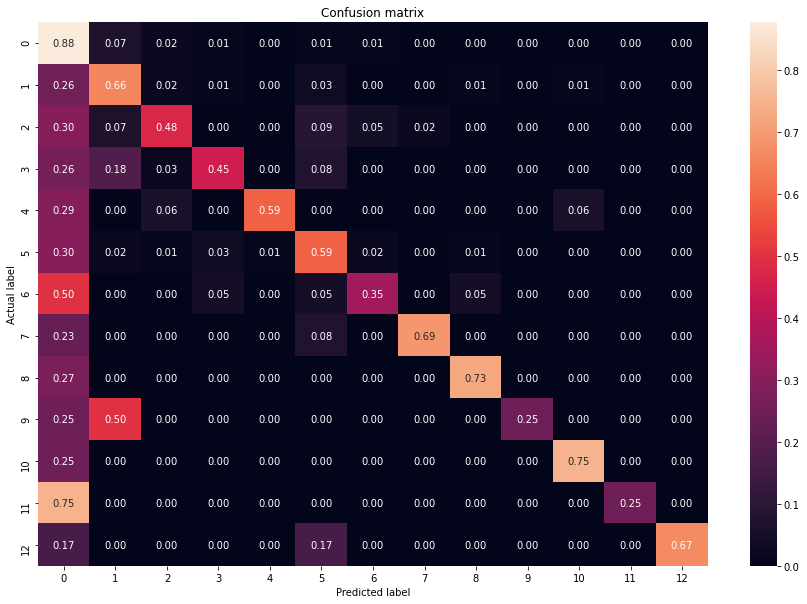

In [20]:
plot_cm(label_test, kmean_pred_test)

## Random Forest

In [21]:
forest_cls = RandomForestClassifier(n_jobs = -1, n_estimators = 5)# , max_depth = 200 , random_state=0)
forest_cls.fit(data_train, label)

RandomForestClassifier(n_estimators=5, n_jobs=-1)

In [22]:
tree_pred = forest_cls.predict(data_train)
tree_mse = mean_squared_error(label, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.05973578091385093

### Testing

In [23]:
tree_pred_test = forest_cls.predict(data_test)
tree_mse_test = mean_squared_error(label_test, tree_pred_test)
tree_rmse_test = np.sqrt(tree_mse_test)
tree_rmse_test

0.15636875283821863

In [24]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1))
f1 = f1_score(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1), average = None)

print('Acccuracy: ', acc)


Acccuracy:  0.7819025522041764


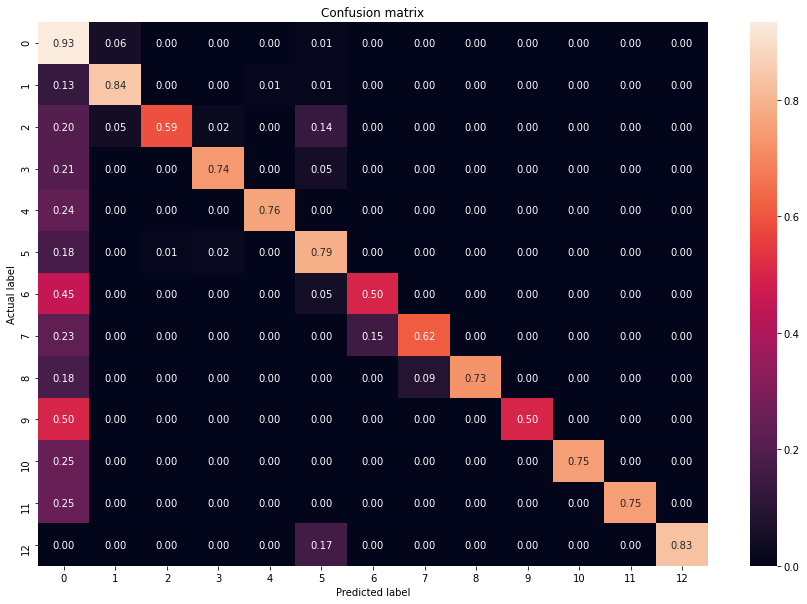

In [25]:
plot_cm(label_test, tree_pred_test)

## SVM

In [34]:
svm_model = SVC(kernel = 'poly', degree = 10, C = 100)

In [35]:
svm_model.fit(data_train, labels) 
svm_predictions = svm_model.predict(data_test)

conf_matrix = confusion_matrix(labels_test, svm_predictions)
acc = accuracy_score(labels_test, svm_predictions)
f1 = f1_score(labels_test, svm_predictions, average = None)

print('Acccuracy: ', acc)

Acccuracy:  0.777262180974478


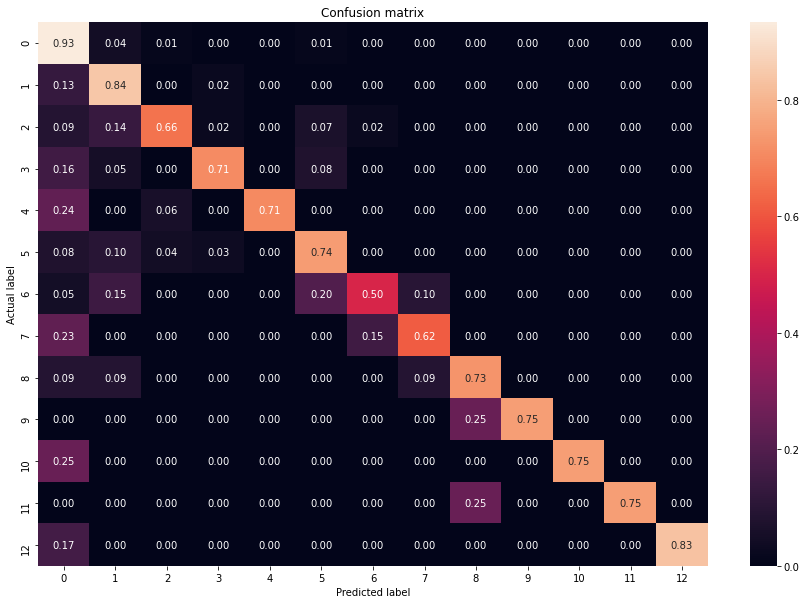

In [36]:
plot_cm(labels_test, svm_predictions)

## Bagging + Decision Tree

In [71]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=10,
            max_samples=500, bootstrap = True, n_jobs = -1)

In [72]:
bag_clf.fit(data_train, labels)
y_pred = bag_clf.predict(data_test)

### Testing

In [73]:
conf_matrix = confusion_matrix(labels_test, y_pred)
acc = accuracy_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred, average = None)

print('Acccuracy: ', acc)


Acccuracy:  0.7819025522041764


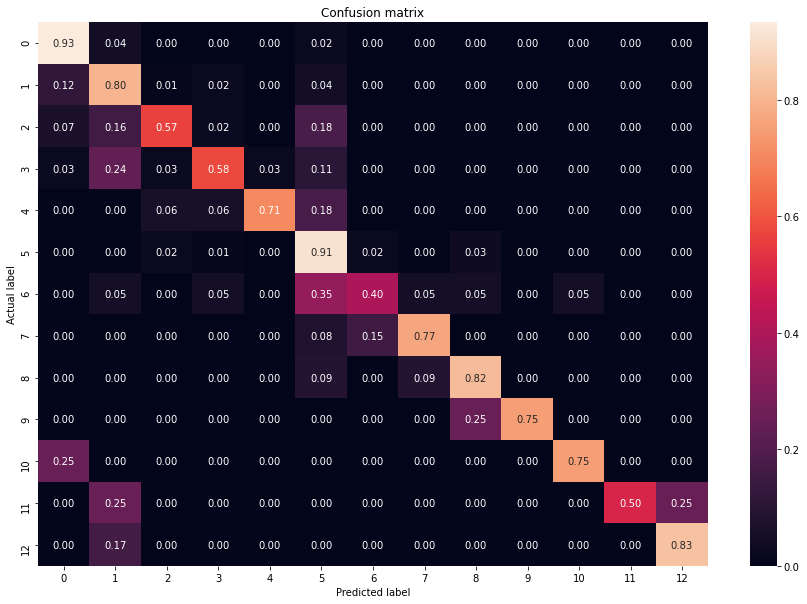

In [74]:
plot_cm(labels_test, y_pred)

## XGBoost

In [41]:
import xgboost as xgb

In [62]:
#xgb.booster.set_param({'predictor': 'gpu_predictor'})
#xgb.booster.inplace_predict(cupy_array)

#xgb.booster.set_param({'predictor': 'cpu_predictor})
#xgb.booster.inplace_predict(numpy_array)

In [42]:
y = tv_categorical['sold_quantity'].copy()
X = full_pipeline.transform(tv_categorical)

In [69]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [110]:
xg_cls = xgb.XGBClassifier(objective ='multi:softmax', n_jobs = -1, colsample_bytree = 0.3, learning_rate = 0.08,
                max_depth = 12, n_estimators = 16)

In [111]:
xg_cls.fit(data_train,labels)

xgb_preds = xg_cls.predict(data_test)

In [112]:
conf_matrix = confusion_matrix(labels_test, xgb_preds)
acc = accuracy_score(labels_test, xgb_preds)

In [113]:
print("Accuracy: ", acc)

Accuracy:  0.8074245939675174


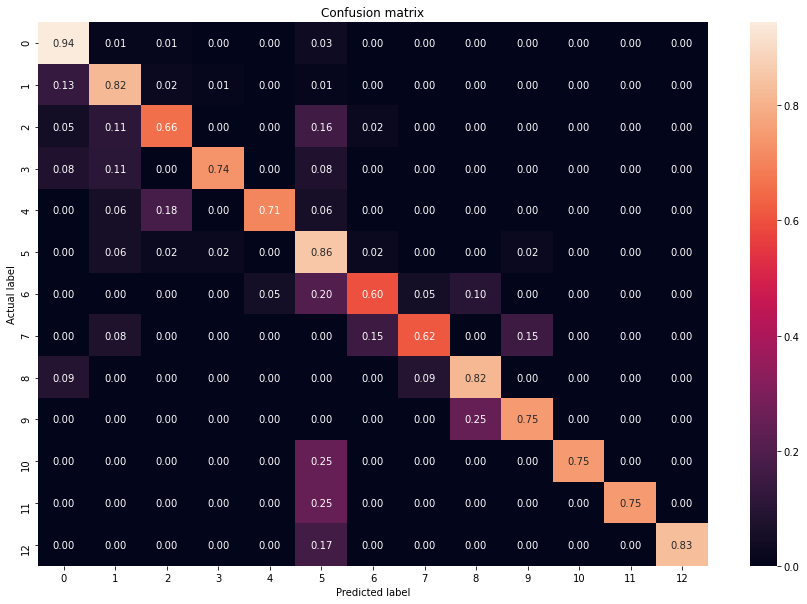

In [114]:
plot_cm(labels_test, xgb_preds)

### feature importance

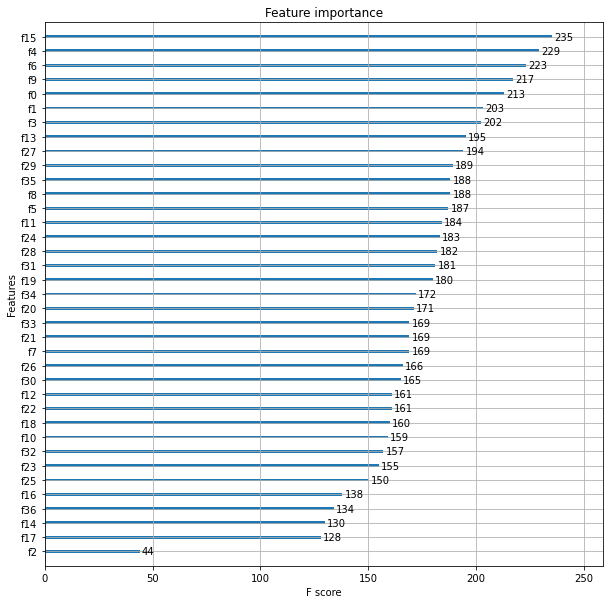

In [119]:
xgb.plot_importance(xg_cls)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [105]:
data_train.shape

(1703, 38)

# Predicting New Downloaded Samples

In [122]:
%load_ext autoreload
%autoreload 2
from modules.itemUtils import get_items

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
item_list = ['MLA822964501']
new_items = get_items(item_list)


In [124]:
new_items['sold_quantity']

0    5
Name: sold_quantity, dtype: int64

In [125]:
for cat in cat_attribbutes:
    new_items[cat].fillna('other', inplace=True)
    
for cat in ord_attribbutes:
    new_items[cat].fillna(0, inplace=True)

new_items = new_items.astype({"seller_years_active": int})
new_items_cat = get_dummies.transform(new_items[cat_attribbutes + ord_attribbutes].values)

new_items_dummies = pd.concat([new_items[other_attribbutes], new_items_cat ], axis=1)

In [126]:
new_items_dummies = full_pipeline.transform(new_items_dummies)

In [127]:
xg_cls.predict(new_items_dummies)

array([5.])

In [128]:
forest_cls.predict(data_test[:2]).argmax(axis=1)

array([5, 3], dtype=int64)

# Cross Validation - Performance

In [12]:
dataset = sample_cat(tv_categorical, 42, efective_sample = 450)

In [13]:
num_pipeline_cv = Pipeline([
    ('selector', NumericalCategoricalSelector(num_features, len(num_features))),
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline_cv = Pipeline([
    ('selector', NumericalCategoricalSelector(cat_features, categorical_dimension)),
    ('dimension_reducer', DimensionReducer(feature_dimension = categorical_dimension, h_layers =(128, 64), latent_dim = 32))#303
])

full_pipeline_cv  = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_cv),
    ('cat_pipeline', cat_pipeline_cv),
])

In [14]:
labels = dataset['sold_quantity'].copy()
data = full_pipeline_cv.fit_transform(dataset)


Train on 2134 samples
Epoch 1/25
2134/2134 [==============================] - 2s 861us/sample - loss: 0.2288
Epoch 2/25
2134/2134 [==============================] - 0s 205us/sample - loss: 0.0788
Epoch 3/25
2134/2134 [==============================] - 0s 202us/sample - loss: 0.0204
Epoch 4/25
2134/2134 [==============================] - 0s 199us/sample - loss: 0.0134
Epoch 5/25
2134/2134 [==============================] - 0s 194us/sample - loss: 0.0107
Epoch 6/25
2134/2134 [==============================] - 0s 193us/sample - loss: 0.0090
Epoch 7/25
2134/2134 [==============================] - 0s 184us/sample - loss: 0.0077
Epoch 8/25
2134/2134 [==============================] - 0s 195us/sample - loss: 0.0067
Epoch 9/25
2134/2134 [==============================] - 0s 194us/sample - loss: 0.0060
Epoch 10/25
2134/2134 [==============================] - 0s 190us/sample - loss: 0.0054
Epoch 11/25
2134/2134 [==============================] - 0s 198us/sample - loss: 0.0049
Epoch 12/25
2134/21

In [22]:
#models
neigh_cv = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
forest_cls_cv = RandomForestClassifier(n_jobs = -1, n_estimators = 5, random_state=28)
dtree_cv = DecisionTreeClassifier(random_state=7, max_depth = 14)

svm_model_cv = SVC(kernel = 'poly', degree = 10, C = 100, random_state=7)
bag_clf_cv = BaggingClassifier(
            DecisionTreeClassifier(random_state=7, class_weight='balanced', max_depth = 14), n_estimators=10,
            max_samples=250, bootstrap = True, n_jobs = -1)

In [23]:
model_dic = {'KNN': neigh_cv, 'DecisionTree': dtree_cv, 'RandomForest': forest_cls_cv, 'Bagging': bag_clf_cv, 'SVM':svm_model_cv}
scoring = ["f1_macro", "accuracy"]

scores_table = pd.DataFrame(columns = ['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput'])

for model in model_dic.keys():
    
    scores = cross_validate(model_dic[model], data, labels, scoring=scoring, cv=5, n_jobs = -1)
    
        
    score_df = pd.DataFrame(pd.DataFrame(scores).mean()).T
    score_df['modelo'] = model
    
    #StratifiedShuffleSplit, usado por cross_validate, por default splitea data en 0.1 para test
    score_df['Throughput'] = (data.shape[0] * 0.1) / score_df['score_time'] 
    score_df[['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput']]
    

    scores_table = pd.concat([scores_table, score_df], ignore_index=True)

In [24]:
scores_table.sort_values(by=['test_f1_macro'], ascending=False)

,modelo,fit_time,score_time,test_f1_macro,test_accuracy,Throughput
2,RandomForest,0.111087,0.103894,0.777538,0.801315,2054.020458
1,DecisionTree,0.051947,0.001798,0.776832,0.800847,118655.311080
4,SVM,0.385606,0.027772,0.765135,0.776009,7684.078137
3,Bagging,0.105691,0.105496,0.652976,0.716036,2022.828686
0,KNN,0.016782,0.127470,0.549073,0.636371,1674.124820


**Para el analisis de performance se dividio el dataset en 5 subsets distintos llamados folds. Luego se entreno y evaluo cada modelo 5 veces, con un subset de datos distinto cada vez.**

**De estas corridas se tomo el accuracy, el f1 score, el tiempo de evaluacion y el throughput (items/seg).**

**De estas 5 corridas, RandomForest presento medidas mas estables de accuracy y f1_macro. Esto implica que no solo el accuracy es bueno, sino que tambien nos asegura que tanto el recall como la precision son cercanas entre ellas y la performance del accuracy no se debe exclusivamente al aporte de alguna de las clases mayoritarias frente al resto.**

**No obstante los scores del arbol de decision son bastantes proximos al de Random Forest con la ventaja que al no ser un ensemble, el tiempo de prediccion es considerablemente mas chico y por lo tanto tambien tiene un Throughput mas alto de items/segundo que puede procesar** 

# Optimizaciones

**Tanto Bagging como Random Forest, no son los modelos mas optimos cuando contamos con clases desbalanceadas. Antes este problema no parecia evidenciarse pero al usar kfolds, lo cual genera splits mas chicos de los datos, esta condicion se agravo. Especialmente en el caso de RandomForest que de por si usa un subset aleatorio del conjunto total de los features**

**Para subsanar este problema podemos recurrir a varias estrategias como under sampling, sampleao con repeticion o asignandole pesos a las clases para compensar dicho desbalance. La primera en parte ya fue utilizada para tratar de corregir en cierta medida el desbalance en un principio.**

**Como medida de comparacion, vamos a incorporar en todos los modelos estrategias de ponderacion de las clases**

## Class Balancing

In [29]:
#models
neigh_cv = KNeighborsClassifier(n_neighbors=5, n_jobs = -1, weights='distance')
forest_cls_cv = RandomForestClassifier(n_jobs = -1, n_estimators = 5, class_weight='balanced', random_state=28)
dtree_cv = DecisionTreeClassifier(random_state=7, max_depth = 14, class_weight='balanced')

svm_model_cv = SVC(kernel = 'poly', degree = 5, C = 100, class_weight='balanced', random_state=7)
bag_clf_cv = BaggingClassifier(
            DecisionTreeClassifier(class_weight='balanced', max_depth = 14), n_estimators=10,
            max_samples=250, bootstrap = True, n_jobs = -1)

In [15]:
model_dic = {'KNN': neigh_cv, 'DecisionTree': dtree_cv, 'RandomForest': forest_cls_cv, 'Bagging': bag_clf_cv, 'SVM':svm_model_cv}
scoring = ["f1_macro", "accuracy"]


scores_table = pd.DataFrame(columns = ['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput'])

for model in model_dic.keys():
    
    scores = cross_validate(model_dic[model], data, labels, scoring=scoring, cv=5, n_jobs = -1)
    
        
    score_df = pd.DataFrame(pd.DataFrame(scores).mean()).T
    score_df['modelo'] = model
    
    #StratifiedShuffleSplit, usado por cross_validate, por default splitea data en 0.1 para test
    score_df['Throughput'] = (data.shape[0] * 0.1) / score_df['score_time'] 
    score_df[['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput']]
    

    scores_table = pd.concat([scores_table, score_df], ignore_index=True)

In [16]:
scores_table.sort_values(by=['test_f1_macro'], ascending=False)

,modelo,fit_time,score_time,test_f1_macro,test_accuracy,Throughput
2,RandomForest,0.115681,0.105892,0.812407,0.815383,2015.270084
1,DecisionTree,0.108489,0.003597,0.805269,0.807404,59334.734743
4,SVM,0.368223,0.035764,0.800294,0.789598,5966.961240
0,KNN,0.017782,0.130267,0.799336,0.791006,1638.179898
3,Bagging,0.108489,0.106691,0.648788,0.711341,2000.167317


**Agregando la ponderacion de las clases se nota como por lo general los modelos se ven beneficiados tanto en accuracy como el score f1. Pero el gran beneficiado fue KNN donde decidio usarce una estrategia de pesos por distancia para definir la clase en base a los vecinos. Esta ya no queda unicamente determinada por la cantidad de vecinos pertenecientes a una clase en un conjunto de 'n' vecinos mas cercanos, sino que a estos se los pondera por la distancia al centro del cluster**

**Por otro lado, baggin parece haberse visto perjudicado minimamente**

## SMOTE

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [16]:
#models
neigh_cv = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
forest_cls_cv = RandomForestClassifier(n_jobs = -1, n_estimators = 5, random_state=28)
dtree_cv = DecisionTreeClassifier(random_state=7, max_depth = 14)

svm_model_cv = SVC(kernel = 'poly', degree = 5, C = 100, random_state=7)
bag_clf_cv = BaggingClassifier(
            DecisionTreeClassifier(random_state=7, class_weight='balanced', max_depth = 14), n_estimators=10,
            max_samples=250, bootstrap = True, n_jobs = -1)

In [19]:
model_dic = {'KNN': neigh_cv, 'DecisionTree': dtree_cv, 'RandomForest': forest_cls_cv, 'Bagging': bag_clf_cv, 'SVM':svm_model_cv}
scoring = ["f1_macro", "accuracy"]



# define pipeline
over = SMOTE("not majority",  n_jobs=-1)
under = RandomUnderSampler('majority')
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)


counter = Counter(labels)
print(counter)
# transform the dataset
new_data, new_labels = pipeline.fit_resample(data, labels)
counter = Counter(new_labels)
print(counter)

scores_table = pd.DataFrame(columns = ['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput'])

for model in model_dic.keys():
    
    scores = cross_validate(model_dic[model], new_data, new_labels, scoring=scoring, cv=5, n_jobs = -1)
        
    score_df = pd.DataFrame(pd.DataFrame(scores).mean()).T
    score_df['modelo'] = model
    
    #StratifiedShuffleSplit, usado por cross_validate, por default splitea data en 0.1 para test
    score_df['Throughput'] = (new_data.shape[0] * 0.1) / score_df['score_time'] 
    score_df[['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput']]
    

    scores_table = pd.concat([scores_table, score_df], ignore_index=True)




Counter({0.0: 450, 1.0: 450, 5.0: 450, 2.0: 219, 3.0: 188, 25.0: 96, 4.0: 84, 50.0: 65, 100.0: 51, 500.0: 27, 250.0: 19, 150.0: 18, 200.0: 17})
Counter({0.0: 450, 1.0: 450, 2.0: 450, 3.0: 450, 4.0: 450, 5.0: 450, 25.0: 450, 50.0: 450, 100.0: 450, 150.0: 450, 200.0: 450, 250.0: 450, 500.0: 450})


In [20]:
scores_table.sort_values(by=['test_f1_macro'], ascending=False)

,modelo,fit_time,score_time,test_f1_macro,test_accuracy,Throughput
4,SVM,0.862916,0.107690,0.932085,0.933675,5432.273668
2,RandomForest,0.117080,0.106491,0.929520,0.929744,5493.400177
1,DecisionTree,0.196598,0.004196,0.908001,0.908376,139414.529711
0,KNN,0.093904,0.210385,0.884035,0.890085,2780.621049
3,Bagging,0.109686,0.107890,0.791687,0.796068,5422.175590


In [21]:
pd.DataFrame(new_labels).sold_quantity.value_counts()

250.0    450
100.0    450
50.0     450
25.0     450
150.0    450
500.0    450
200.0    450
5.0      450
4.0      450
3.0      450
2.0      450
1.0      450
0.0      450
Name: sold_quantity, dtype: int64

In [22]:
pd.DataFrame(labels).sold_quantity.value_counts()

5.0      450
1.0      450
0.0      450
2.0      219
3.0      188
25.0      96
4.0       84
50.0      65
100.0     51
500.0     27
250.0     19
150.0     18
200.0     17
Name: sold_quantity, dtype: int64

**Finalmente presentamos SMOTE o Synthetic Minority Oversampling Technique. Esta es una clase de aumeentacion de datos en donde se sintetizan nuevos datos para las clases minoritarias.**

**La forma en la que SMOTE resuelve este problema consiste en seleccionar muestras que estan cercas en el espacio de los features, dibujar una linea entree dichas muestras y finalmente generar una nueva muestra mediante el establecimiento de un punto a lo largo de dicha linea.**

**El punto debil de este algoritmo es an aquellas clases donde realmente hay muy pocas muestras y donde su vecino mas cercano tal vez sea un punto perteneciente a otra clase por lo que puedee terminar generando puntos perteenecientes a otra categoria, estando generando entonces outliers y pudiendo perjudicar la performance del modelo**

## Inconsistencia con el scoring en sklearn

In [148]:
dtree_cv = DecisionTreeClassifier(random_state=7)
dtree_cv.fit(data_train, labels)
y_pred = dtree_cv.predict(data_test)

Acccuracy:  0.8097447795823666


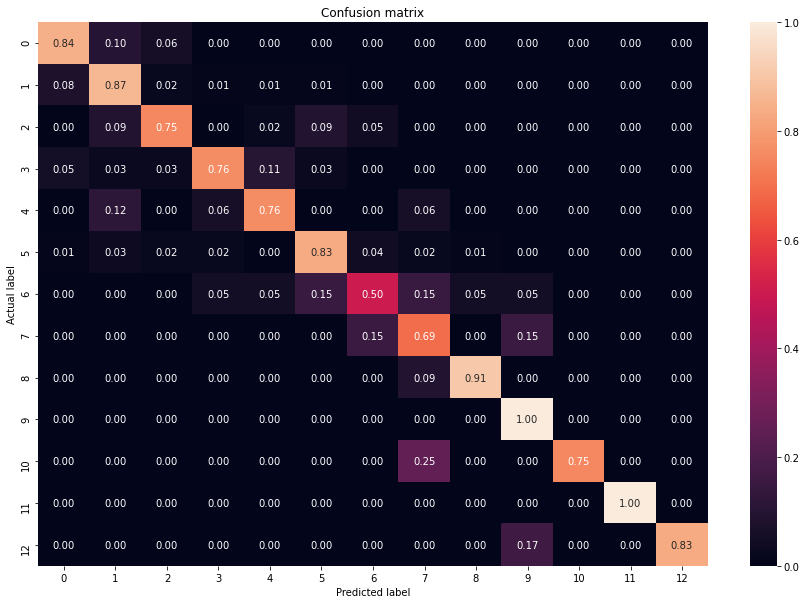

In [149]:
conf_matrix = confusion_matrix(labels_test, y_pred)
acc = accuracy_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred, average = None)

print('Acccuracy: ', acc)
plot_cm(labels_test, y_pred)

In [150]:
dtree_cv = DecisionTreeClassifier(random_state=7)
dtree_cv.fit(data_train, label)
y_pred = dtree_cv.predict(data_test)

Acccuracy:  0.8097447795823666


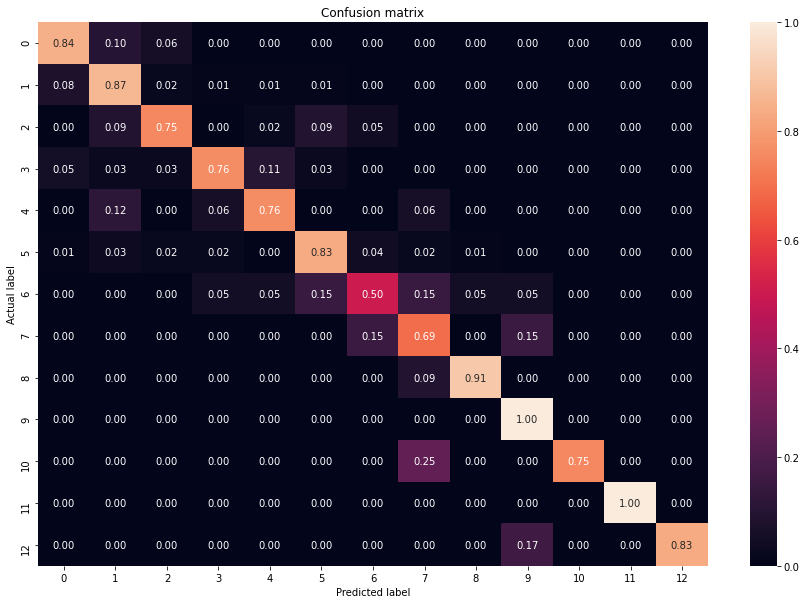

In [152]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), y_pred.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), y_pred.argmax(axis=1))
f1 = f1_score(label_test.argmax(axis=1), y_pred.argmax(axis=1), average = None)

print('Acccuracy: ', acc)
plot_cm(label_test.argmax(axis=1), y_pred.argmax(axis=1))

**Cuando se mezclan las etiquetas en forma ordinal con el argumento maximo del onehot, el accuracy efectivamente baja porque mas alla de la categoria con 5 items vendidos, los numeros ya no coinciden (25 != 6, 50 !=7, etc). Por alguna razon, el cross validate pareciera estar cotiendo este error cuando le pasamos las etiquetas como un vector de (n_samples, n_categories)**

if model == 'SVM' or model == 'Bagging':

    scores = cross_validate(model_dic[model], data, labels, scoring=scoring, cv=5, n_jobs = -1)

else:

    scores = cross_validate(model_dic[model], data, **label**, scoring=scoring, cv=5, n_jobs = -1)
    
    
**label, a diferencia de labels, es un vector de (n_samples, n_categories). Originalmente se modelaron asi loc clasificadores pero al final con la incorporacion de bagging y svm, estos exigian tener la etiquetas en sus expresiones numericas para realizar el fit (y:array-like of shape (n_samples,))**

**Finalmente, para estandarizar criterios y evitar este inconveninete, se dejo las etiquetas como sus representaciones numericas ya que todos los modelos son capaces de procesarlas de esta manera.

Acccuracy:  0.7053364269141531


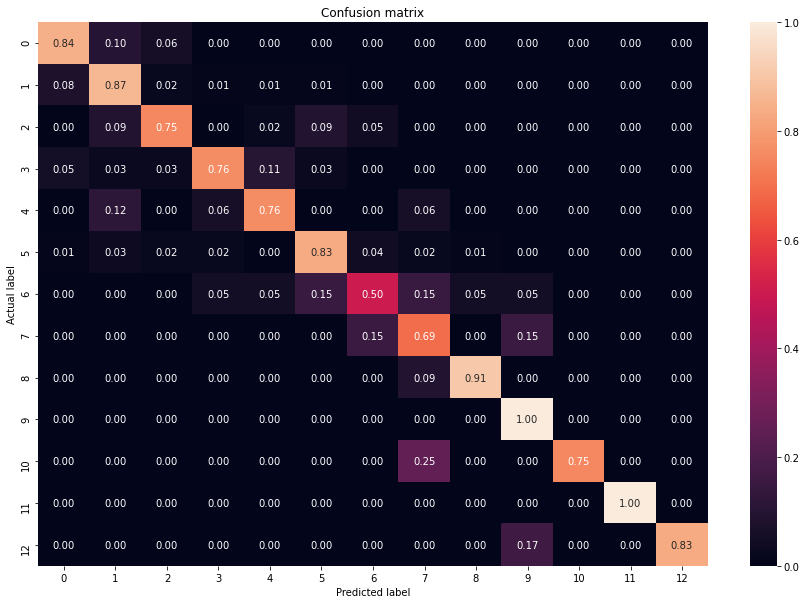

In [153]:
conf_matrix = confusion_matrix(labels_test, y_pred.argmax(axis=1))
acc = accuracy_score(labels_test, y_pred.argmax(axis=1))
f1 = f1_score(labels_test, y_pred.argmax(axis=1), average = None)

print('Acccuracy: ', acc)
plot_cm(label_test, y_pred)